In [1]:
from slvsh_tr import load_examples

# 一個目のデータを試しに表示

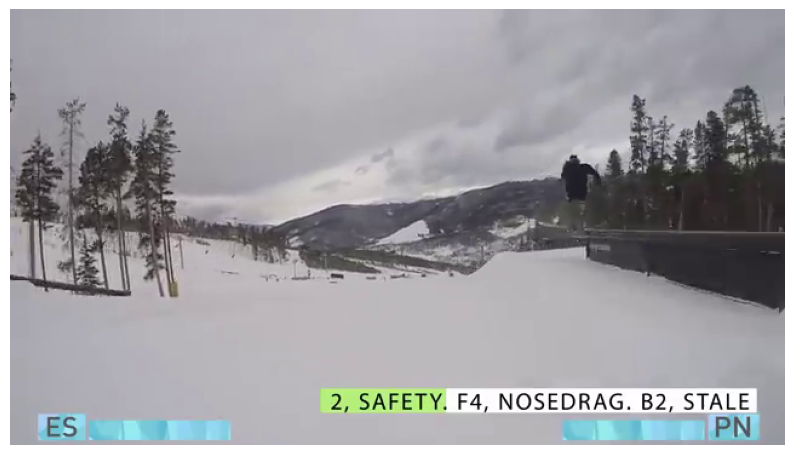

In [2]:
import cv2
import matplotlib.pyplot as plt

examples = load_examples()
image = examples[2].get_image()
# Convert BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.imshow(image_rgb)
plt.show()


# 試しに常に NOLLIE と予測するモデルを作る

In [3]:
from slvsh_tr import Recognizer

model = Recognizer.from_func(lambda image: "NOLLIE")
model.infer(image)

'NOLLIE'

# NOLLIE モデルを評価

In [1]:
from slvsh_tr import eval
import pandas as pd

result = eval(model)

# 評価結果をDataFrameに変換
df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)


ModuleNotFoundError: No module named 'pandas'

# 評価結果の説明
- precision: 予測が正解に含まれている割合
- recall: 正解が予測に含まれている割合
- f1: precisionとrecallの調和平均，両方ともバランスとってみれる指標

例えば正解 "NOLLIE 2 BACK SWAP" に "NOLLIE 2" と予測した場合

- Precision は 100%
- Recall は 50%

Recallが低い時は，なんか見逃してる

正解 "NOLLIE 2 BACK SWAP"に"NOLLIE 2 BACK SWAP SW"と予測した場合

- Precision は 80%
- Recall は 100%

Precisionが低い時は，間違ってる出力が出てる

# もうちょっと複雑なモデル

OCR使うパターン

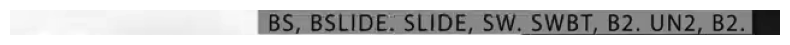

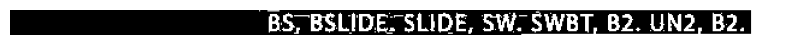

'BS, BSLIDE. SLIDE, SW. SWBT, B2. UN2, B2.'

In [5]:
from slvsh_tr import Recognizer
import pytesseract

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(image, 'gray')
    plt.show()

class TesseractRecognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), :]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, thresh_image = cv2.threshold(gray_frame, 100, 255, cv2.THRESH_BINARY_INV)

        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'
        extracted_text = pytesseract.image_to_string(thresh_image, config=config).strip()

        if self.debug:
            display_image(gray_frame)
            display_image(thresh_image)

        return extracted_text

model = TesseractRecognier(debug=True)
model.infer(examples[1].get_image())



In [6]:
model = TesseractRecognier()
result = eval(model)

Evaluating examples: 100%|██████████| 178/178 [01:04<00:00,  2.76it/s]


In [7]:
df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

precision    0.558326
recall       0.787366
f1           0.572439
dtype: float64

# 個々の結果の詳細をみてみる

In [8]:
df

,prediction,expected,precision,recall,f1
0,,,1.000000,1.000000,1.000000
1,REVENGE BIBS,REVENGE UN SW5 NOSE.,0.500000,0.200000,0.285714
2,SR OY 7 OREN,"WALLRIDE, SW 3.",0.000000,0.000000,0.000000
3,"2, SAFETY. F4, NOSEDRAG. B2, STALE","2, SAFETY. F4, NOSEDRAG. B2, STALE",1.000000,1.000000,1.000000
4,"MSWLIP, SW. SWLIP, SW","SWLIP, SW. SWLIP, SW",0.857143,0.857143,0.857143
...,...,...,...,...,...
173,"SUPERMAN FRONT. BCORK 810, BLUNT.","SUPERMAN FRONT. BCORK 810, BLUNT.",1.000000,1.000000,1.000000
174,"6SS2, DISASTER, FWD. FSLIDE TO BSLIDE, FWD","2, DISASTER, FWD. FSLIDE TO BSLIDE, FWD",0.909091,0.909091,0.909091
175,"R CORK 5, BLUNT.","R CORK 5, BLUNT.",1.000000,1.000000,1.000000
176,"A, LIP, BSLIDE, SW. SW4, F2. SW1.","LIP, BSLIDE, SW. SW4, F2. SW1.",0.857143,1.000000,0.923077


In [9]:
# Precisionが低いやつ
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
2,SR OY 7 OREN,"WALLRIDE, SW 3.",0.0,0.0,0.0
6,I,,0.0,1.0,0.0
15,,"B3S, 2.",0.0,0.0,0.0
9,", ST 0U ET CU GEG LULULUUCCSYS",,0.0,1.0,0.0
21,O1.4,"9, CORK.",0.0,0.0,0.0
18,TS 7,"2, B2. BS, B2.",0.0,0.0,0.0
17,ST,"B3S, SW. SW4.",0.0,0.0,0.0
16,CT C 0606 WCCCCC CSS,F4. B6. NOLLIE 1.,0.0,0.0,0.0
24,MY,,0.0,1.0,0.0
28,0S,"SWTB1, PB7",0.0,0.0,0.0
